# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import os
# Set environment variables for JAX and GPU configuration
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Use GPU 0
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
# Disable XLA optimizations that might cause timing issues
os.environ['XLA_FLAGS'] = '--xla_gpu_triton_gemm_any=false'

import jax
# Enable persistent compilation cache.
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update(
    "jax_persistent_cache_enable_xla_caches", "xla_gpu_per_fusion_autotune_cache_dir"
)
import sparse

from pathlib import Path
from natsort import natsorted
from src.utils import io_dict_to_hdf5 as ioh5
from src.utils.plot_utils import *
from src.simulation.vnc_sim import *
from src.utils.path_utils import *
from omegaconf import OmegaConf
from tqdm.auto import tqdm
# Ensure custom resolvers are registered
# This is important when loading saved configs that contain custom interpolations
from src.utils.path_utils import register_custom_resolvers
register_custom_resolvers()

#### Utility Functions ####
def print_pytree(pytree):
   """
   path_filter: function that takes key_path tuple and returns True/False
   """
   def process_leaf(key_path, leaf):
      print(f"Key Path: {key_path[0]}, Leaf: {leaf.shape} of type {leaf.dtype if hasattr(leaf, 'dtype') else type(leaf)}")

   return jax.tree.map_with_path(process_leaf, pytree)

def print_dict_shapes(data, prefix="", max_depth=10, current_depth=0):
   """
   Recursively print shapes for arrays and values for other types in a dictionary.
   
   Args:
      data: Dictionary or other data structure to inspect
      prefix: String prefix for indentation
      max_depth: Maximum recursion depth to prevent infinite loops
      current_depth: Current recursion depth
   """
   import jax.numpy as jnp
   import numpy as np
   
   if current_depth > max_depth:
      print(f"{prefix}... (max depth reached)")
      return
   
   if isinstance(data, dict):
      for key, value in data.items():
         print(f"{prefix}{key}:")
         print_dict_shapes(value, prefix + "  ", max_depth, current_depth + 1)
   
   elif isinstance(data, (list, tuple)):
      print(f"{prefix}Type: {type(data).__name__}, Length: {len(data)}")
      if len(data) > 0:
         print(f"{prefix}First element:")
         print_dict_shapes(data[0], prefix + "  ", max_depth, current_depth + 1)
         if len(data) > 1:
               print(f"{prefix}... ({len(data)-1} more elements)")
   
   elif hasattr(data, 'shape'):  # Arrays (JAX, NumPy, etc.)
      print(f"{prefix}Type: {type(data).__name__}, Shape: {data.shape}, Dtype: {data.dtype}")
   
   elif isinstance(data, (int, float, bool, str)):
      print(f"{prefix}Type: {type(data).__name__}, Value: {data}")
   
   elif hasattr(data, '__dict__'):  # Objects with attributes
      print(f"{prefix}Type: {type(data).__name__}")
      for attr_name in dir(data):
         if not attr_name.startswith('_'):  # Skip private attributes
               try:
                  attr_value = getattr(data, attr_name)
                  if not callable(attr_value):  # Skip methods
                     print(f"{prefix}  {attr_name}:")
                     print_dict_shapes(attr_value, prefix + "    ", max_depth, current_depth + 1)
               except:
                  print(f"{prefix}  {attr_name}: <unable to access>")
   
   else:
      print(f"{prefix}Type: {type(data).__name__}, Value: {str(data)[:100]}{'...' if len(str(data)) > 100 else ''}")

Using diffeqsolve-based neural simulation (original)


If just starting out, run: 

```
python test_configs.py experiment.n_replicates=8 paths=YOUR_PATH_YAML 
```

In [2]:
%run ../test_configs.py experiment.n_replicates=8 paths=walle-smpuglie

version: default
num_gpus: ''
run_id: testing
load_jobid: ''
note: ''
experiment:
  name: DNg100_Stim
  wPath: /home/smpuglie/Pugliese_2025/data/manc t1 connectome data/W_20250813_DNtoMN_unsorted.csv
  dfPath: /home/smpuglie/Pugliese_2025/data/manc t1 connectome data/wTable_20250813_DNtoMN_unsorted_withModules.csv
  n_replicates: 8
  batch_size: null
  dn_screen: false
  stimNeurons:
  - - 31
  removeNeurons: []
  keepOnly: []
  stimI:
  - - 250
  seed: 1
  saveFigs: true
  useTsp: false
  save_checkpoints: false
  max_pruning_iterations: 200
  oscillation_threshold: 0.5
neuron_params:
  name: TestingNeuronParams
  tauMean: 0.02
  tauStdv: 0.002
  aMean: 1
  aStdv: 0.1
  thresholdMean: 7.5
  thresholdStdv: 0.6
  frcapMean: 200
  frcapStdv: 10
  excitatoryMultiplier: 0.03
  inhibitoryMultiplier: 0.03
paths:
  user: smpuglie
  cwd_dir: !!python/object/apply:pathlib._local.PosixPath
  - /home/smpuglie/Pugliese_2025/notebooks
  base_dir: !!python/object/apply:pathlib._local.PosixPath
  - /

In [3]:
# Specify experiment and version
experiment = 'DNg100_Stim'
version = 'default'

#### List available configs ####
base_dir = Path(f'/data/users/smpuglie/Pugliese_2025/{experiment}/{version}') # ⚠️ Change this to your local base_dir ⚠️
run_cfg_list = natsorted(list(Path(base_dir).rglob('run_config.yaml')))
for n, run_cfg in enumerate(run_cfg_list):
    print(n, run_cfg)

###### Load and update config with specified paths template ###### 
cfg_num = -1

# NEW APPROACH: Load config and replace paths using glados.yaml template
cfg = load_config_with_path_template(
    config_path=run_cfg_list[cfg_num],
    paths_template="walle-smpuglie",     # ⚠️ Change this to your local paths .yaml ⚠️
    experiment=experiment,               # This will override if needed
    version=version,                     # Use debug version locally instead of hyak
)

print(f'✅ Loaded experiment: {cfg.experiment.name}')

# Convert string paths to Path objects and create directories
try:
    cfg.paths = convert_dict_to_path(cfg.paths)
    print("✅ Successfully converted all paths to Path objects and created directories")
except Exception as e:
    print(f"⚠️  Warning: Could not convert all paths: {e}")
    print("Proceeding with string paths and manual directory creation...")
    # If conversion fails, create the directories manually
    for key, path_str in cfg.paths.items():
        if key != 'user' and isinstance(path_str, str):
            path_obj = Path(path_str)
            path_obj.mkdir(parents=True, exist_ok=True)
            cfg.paths[key] = path_obj

checkpoint_dir = None
if cfg.sim.enable_checkpointing and hasattr(cfg, 'paths'):
    checkpoint_dir = Path(cfg.paths.ckpt_dir) / "checkpoints"


0 /data/users/smpuglie/Pugliese_2025/DNg100_Stim/default/run_id=testing/logs/run_config.yaml
📁 Loading config from: /data/users/smpuglie/Pugliese_2025/DNg100_Stim/default/run_id=testing/logs/run_config.yaml
✅ Loaded experiment: DNg100_Stim
✅ Successfully converted all paths to Path objects and created directories


# Example params

In [4]:
print("Loading network configuration...")
W_table = load_wTable(cfg.experiment.dfPath)
n_stim_configs = len(cfg.experiment.stimNeurons)

# Prepare parameters
load_new_params = True # Set to False to load existing params from neuron_params.h5
if load_new_params:
    neuron_params_path = None
    if 'neuron_params' in vars():
        del neuron_params  # Clear existing params to avoid confusion
        gc.collect()
        jax.clear_caches()
        print('Cleared existing neuron_params and JAX caches')
else:
    neuron_params_path = cfg.paths.ckpt_dir / 'neuron_params.h5'
    

neuron_params = prepare_neuron_params(cfg, W_table, neuron_params_path)
sim_params = prepare_sim_params(cfg, n_stim_configs, neuron_params.W.shape[0])
mn_mask = jnp.isin(jnp.arange(sim_params.n_neurons), neuron_params.mn_idxs)
sim_config = parse_simulation_config(cfg)

print_pytree(neuron_params)

Loading network configuration...


INFO:2025-09-18 00:27:35,915:jax._src.xla_bridge:752: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


[2025-09-18 00:27:35,915][jax._src.xla_bridge][INFO] - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
Created 1 stimulus configurations
Key Path: .W, Leaf: (4604, 4604) of type float32
Key Path: .tau, Leaf: (8, 4604) of type float32
Key Path: .a, Leaf: (8, 4604) of type float32
Key Path: .threshold, Leaf: (8, 4604) of type float32
Key Path: .fr_cap, Leaf: (8, 4604) of type float32
Key Path: .input_currents, Leaf: (1, 8, 4604) of type float32
Key Path: .seeds, Leaf: (8, 2) of type uint32
Key Path: .exc_dn_idxs, Leaf: (933,) of type int32
Key Path: .inh_dn_idxs, Leaf: (385,) of type int32
Key Path: .exc_in_idxs, Leaf: (1484,) of type int32
Key Path: .inh_in_idxs, Leaf: (1658,) of type int32
Key Path: .mn_idxs, Leaf: (144,) of type int32
Key Path: .W_mask, Leaf: (8, 4604, 4604) of type bool


NeuronParams(W=None, tau=None, a=None, threshold=None, fr_cap=None, input_currents=None, seeds=None, exc_dn_idxs=None, inh_dn_idxs=None, exc_in_idxs=None, inh_in_idxs=None, mn_idxs=None, W_mask=None)

If you ran the test config code above you will notice there are n_replicates=8 in the leading dimensions for the biophysical parameters. Input currents have an additional dimension for simulating different stimulation conditions in parallel. 

# Single Simulation Example

In [5]:
start_time = time.time()
stim_idx = 0 # Select which stimulation configuration to simulate
param_idx = 0 # Select which parameter replicate to simulate
neuron_params_single = jax.tree.map(lambda x: x[param_idx], neuron_params)
print_pytree(neuron_params_single)

key = jax.random.PRNGKey(0)
W_reweighted = reweight_connectivity(
    neuron_params.W, 
    sim_params.exc_multiplier, 
    sim_params.inh_multiplier
)

# Run the final simulation with pruned network
final_results = run_single_simulation(
    W_reweighted,
    neuron_params_single.tau,
    neuron_params_single.a, 
    neuron_params_single.threshold,
    neuron_params_single.fr_cap,
    neuron_params_single.input_currents[param_idx]*2,
    sim_params.noise_stdv,
    sim_params.t_axis,
    sim_params.T,
    sim_params.dt,
    sim_params.pulse_start,
    sim_params.pulse_end,
    sim_params.r_tol,
    sim_params.a_tol,
    key
)
final_results.block_until_ready()
end_time = time.time()
print("\n🎯 Final simulation results:")
print('Final results shape:', final_results.shape)
print('Simulation time (s):', end_time - start_time)

Key Path: .W, Leaf: (4604,) of type float32
Key Path: .tau, Leaf: (4604,) of type float32
Key Path: .a, Leaf: (4604,) of type float32
Key Path: .threshold, Leaf: (4604,) of type float32
Key Path: .fr_cap, Leaf: (4604,) of type float32
Key Path: .input_currents, Leaf: (8, 4604) of type float32
Key Path: .seeds, Leaf: (2,) of type uint32
Key Path: .exc_dn_idxs, Leaf: () of type int32
Key Path: .inh_dn_idxs, Leaf: () of type int32
Key Path: .exc_in_idxs, Leaf: () of type int32
Key Path: .inh_in_idxs, Leaf: () of type int32
Key Path: .mn_idxs, Leaf: () of type int32
Key Path: .W_mask, Leaf: (4604, 4604) of type bool

🎯 Final simulation results:
Final results shape: (4604, 2001)
Simulation time (s): 5.863175392150879


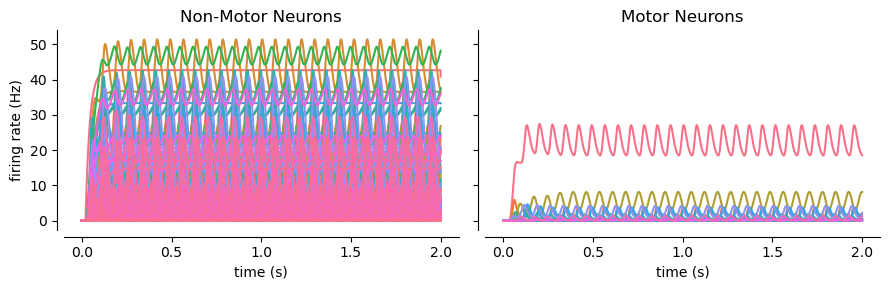

In [6]:
R = final_results
w_table = pd.read_csv(cfg.experiment.dfPath,index_col=0)
mn_mask = jnp.isin(jnp.arange(sim_params.n_neurons), neuron_params.mn_idxs)
nonmns_idxs = jnp.where((jnp.sum(R,axis=-1)>0.01) & ~mn_mask)[0]
mn_idxs = jnp.where((jnp.sum(R,axis=-1)>0.01) & mn_mask)[0]

fig, axs = plt.subplots(1,2,sharex=True,sharey=True)
ax = axs[0]
# for i in nonmns_idxs:
#     ax.plot(R[i])
plot_R_traces(np.asarray(R),w_table.loc[nonmns_idxs],cmap=sns.husl_palette(as_cmap=True),labels=False,ax=ax)
add_tAxis(ax,sim_params.T,4)
sns.despine(offset=5,ax=ax)

ax.set_title("Non-Motor Neurons")
ax.set_ylabel("firing rate (Hz)")
ax.set_xlabel("time (s)")

ax = axs[1]
plot_R_traces(np.asarray(R),sort_motor_modules(w_table.loc[mn_idxs]),sns.husl_palette(as_cmap=True),ax=ax)
add_tAxis(ax,sim_params.T,4)
sns.despine(offset=5,ax=ax)
ax.get_legend().remove()

ax.set_title("Motor Neurons")
ax.set_ylabel("")
ax.set_xlabel("time (s)")

fig.set_figheight(3)
fig.set_figwidth(9)
plt.tight_layout()
plt.show()

# Vmap for parallel simulations

Assuming you ran the `test_config.py`, we will now run a 'batch' of simulations in parallel with vmap using the `process_batch_baseline` funciton. 

In [8]:
from src.simulation.vnc_sim import process_batch_baseline
start_time = time.time()
batch_inds = jnp.arange(sim_params.n_param_sets * sim_params.n_stim_configs)
jit_batch_sim = jax.jit(process_batch_baseline)
# Run the final simulation with pruned network
final_results = jit_batch_sim(
    neuron_params,
    sim_params,
    batch_inds
)
final_results.block_until_ready()
end_time = time.time()
print("\n🎯 Final simulation results:")
print('Final results shape:', final_results.shape)
print('Simulation time (s):', end_time - start_time)


🎯 Final simulation results:
Final results shape: (8, 4604, 2001)
Simulation time (s): 6.446413278579712


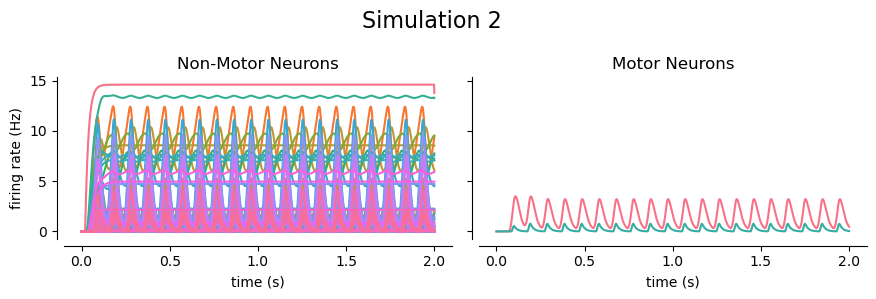

In [9]:
sim_idx = 2
R = final_results[sim_idx]
w_table = pd.read_csv(cfg.experiment.dfPath,index_col=0)
mn_mask = jnp.isin(jnp.arange(sim_params.n_neurons), neuron_params.mn_idxs)
nonmns_idxs = jnp.where((jnp.sum(R,axis=-1)>0.01) & ~mn_mask)[0]
mn_idxs = jnp.where((jnp.sum(R,axis=-1)>0.01) & mn_mask)[0]

fig, axs = plt.subplots(1,2,sharex=True,sharey=True)
ax = axs[0]
# for i in nonmns_idxs:
#     ax.plot(R[i])
plot_R_traces(np.asarray(R),w_table.loc[nonmns_idxs],cmap=sns.husl_palette(as_cmap=True),labels=False,ax=ax)
add_tAxis(ax,sim_params.T,4)
sns.despine(offset=5,ax=ax)

ax.set_title("Non-Motor Neurons")
ax.set_ylabel("firing rate (Hz)")
ax.set_xlabel("time (s)")

ax = axs[1]
plot_R_traces(np.asarray(R),sort_motor_modules(w_table.loc[mn_idxs]),sns.husl_palette(as_cmap=True),ax=ax)
add_tAxis(ax,sim_params.T,4)
sns.despine(offset=5,ax=ax)
ax.get_legend().remove()

ax.set_title("Motor Neurons")
ax.set_ylabel("")
ax.set_xlabel("time (s)")

plt.suptitle(f"Simulation {sim_idx}",fontsize=16)

fig.set_figheight(3)
fig.set_figwidth(9)
plt.tight_layout()
plt.show()

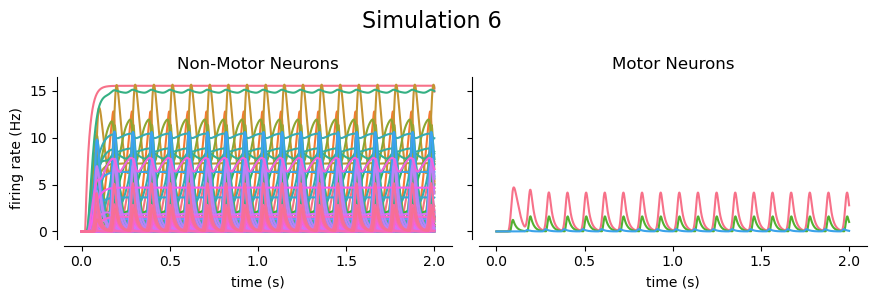

In [10]:
sim_idx = 6
R = final_results[sim_idx]
w_table = pd.read_csv(cfg.experiment.dfPath,index_col=0)
mn_mask = jnp.isin(jnp.arange(sim_params.n_neurons), neuron_params.mn_idxs)
nonmns_idxs = jnp.where((jnp.sum(R,axis=-1)>0.01) & ~mn_mask)[0]
mn_idxs = jnp.where((jnp.sum(R,axis=-1)>0.01) & mn_mask)[0]

fig, axs = plt.subplots(1,2,sharex=True,sharey=True)
ax = axs[0]
# for i in nonmns_idxs:
#     ax.plot(R[i])
plot_R_traces(np.asarray(R),w_table.loc[nonmns_idxs],cmap=sns.husl_palette(as_cmap=True),labels=False,ax=ax)
add_tAxis(ax,sim_params.T,4)
sns.despine(offset=5,ax=ax)

ax.set_title("Non-Motor Neurons")
ax.set_ylabel("firing rate (Hz)")
ax.set_xlabel("time (s)")

ax = axs[1]
plot_R_traces(np.asarray(R),sort_motor_modules(w_table.loc[mn_idxs]),sns.husl_palette(as_cmap=True),ax=ax)
add_tAxis(ax,sim_params.T,4)
sns.despine(offset=5,ax=ax)
ax.get_legend().remove()

ax.set_title("Motor Neurons")
ax.set_ylabel("")
ax.set_xlabel("time (s)")

plt.suptitle(f"Simulation {sim_idx}",fontsize=16)

fig.set_figheight(3)
fig.set_figwidth(9)
plt.tight_layout()
plt.show()

## Checkpoint Loading

Checkpoints are saved when running large scale simulations, in case they are ever interuppted you can resume the simulations from where you left off. Each checkpoint contains all the simulations up until that point. For example, checkpoint_500 will contain simulations 0-500, and will resume start at 501. 

In [ ]:
latest_checkpoint, base_name = find_latest_checkpoint(checkpoint_dir)
print(latest_checkpoint)
checkpoint_state, adjusted_neuron_params, metadata = load_checkpoint(
    latest_checkpoint, base_name, neuron_params
)

In [ ]:
sim_idx = 785
R = checkpoint_state.results_dict[sim_idx]
w_table = pd.read_csv(cfg.experiment.dfPath,index_col=0)
mn_mask = jnp.isin(jnp.arange(sim_params.n_neurons), neuron_params.mn_idxs)
nonmns_idxs = jnp.where((jnp.sum(R,axis=-1)>0.01) & ~mn_mask)[0]
mn_idxs = jnp.where((jnp.sum(R,axis=-1)>0.01) & mn_mask)[0]

fig, axs = plt.subplots(1,2, figsize=(18, 6))
for i in nonmns_idxs:
    axs[0].plot(R[i])
axs[0].set_title("Non-Motor Neurons")
for i in mn_idxs:
    axs[1].plot(R[i])
axs[1].set_title("Motor Neurons")

In [ ]:
results = jnp.asarray([checkpoint_state.results_dict[sim_idx] for sim_idx in checkpoint_state.results_dict.keys()])[None,...]
min_circuit = jnp.asarray([checkpoint_state.mini_circuits_dict[sim_idx] for sim_idx in checkpoint_state.mini_circuits_dict.keys()], dtype=jnp.bool_)

# Load Pruning results

In [ ]:
from src.utils.sim_utils import compute_oscillation_score, neuron_oscillation_score

results = sparse.load_npz(cfg.paths.ckpt_dir / f"{cfg.experiment.name}_Rs.npz").todense().astype(np.float32)
min_circuit = sparse.load_npz(cfg.paths.ckpt_dir / f"{cfg.experiment.name}_mini_circuits.npz").todense()

In [ ]:
R = results[0,0]
# R = final_results
w_table = pd.read_csv(cfg.experiment.dfPath,index_col=0)
mn_mask = jnp.isin(jnp.arange(sim_params.n_neurons), neuron_params.mn_idxs)
nonmns_idxs = jnp.where((jnp.sum(R,axis=-1)>0.01) & ~mn_mask)[0]
mn_idxs = jnp.where((jnp.sum(R,axis=-1)>0.01) & mn_mask)[0]

fig, axs = plt.subplots(1,2, figsize=(18, 6))
for i in nonmns_idxs:
    axs[0].plot(R[i])
axs[0].set_title("Non-Motor Neurons")
for i in mn_idxs:
    axs[1].plot(R[i])
axs[1].set_title("Motor Neurons")

In [ ]:
from src.utils.sim_utils import compute_oscillation_score
clip_start = 250# int(sim_params.pulse_start / sim_params.dt) + 200
def compute_osc_score_all(R, mn_mask, clip_start=250):
    # Get active MN activity using JAX-compatible approach
    max_frs = jnp.max(R[..., clip_start:], axis=-1)
    active_mask = ((max_frs > 0.01) & mn_mask)

    # Compute oscillation score
    oscillation_score, _ = compute_oscillation_score(R[..., clip_start:], active_mask, prominence=0.05)
    return oscillation_score


# osc_score_all = osc_vmap(results[0], mn_mask, clip_start)
osc_score_all = []
for replicate in tqdm(range(results.shape[1])):
    osc_score = compute_osc_score_all(results[0,replicate], mn_mask, clip_start=clip_start)
    osc_score_all.append(osc_score)
osc_score_all = jnp.array(osc_score_all)
n_neurons_mini = jnp.array([len(jnp.where(min_circuit[n] & ~mn_mask)[0]) for n in range(min_circuit.shape[0])])


In [ ]:
[jnp.where(min_circuit[n] & ~mn_mask)[0] for n in range(min_circuit.shape[0])]

In [ ]:
plt.scatter(osc_score_all, n_neurons_mini )
plt.axvline(x=0.25,c='k',ls='--')